# Lesion classification

In [1]:
import sys 
import os
sys.path.append(os.path.abspath("/net/people/plgamyshenin/masters-thesis---melanoma-analysis-with-fnn/experiment--2"))

In [2]:
import numpy as np
import tensorflow as tf
import tensorflow_addons as tfa
import matplotlib.pyplot as plt
from IPython.display import Image, display

from libs.isic import load
from libs.auc import calculate_auc
from libs.gradcam import display_gradcam, make_gradcam_heatmap, get_img_array

In [3]:
tf.get_logger().setLevel('ERROR')

## Hyperparameter definition

In [4]:
strategy = tf.distribute.MirroredStrategy()

In [5]:
with strategy.scope():
    EPOCHS = 200
    SAMPLE_NUMBER = None
    
    TARGET_WIDTH, TARGET_HEIGHT = 299, 299
    O_MODEL = tf.keras.applications.inception_resnet_v2.InceptionResNetV2(
        include_top=False,
        weights='imagenet',
        input_shape=(TARGET_WIDTH, TARGET_HEIGHT, 3),
        pooling='avg'
    )
    RETRAINABLE_LAYERS = ['conv_7b']
    LAST_LAYER = 'conv_7b'
    PREPROCESSING = tf.keras.applications.inception_resnet_v2.preprocess_input

## Load the ISIC Archive dataset

In [6]:
(training_set, validation_set, testing_set), class_weights, class_number = load(SAMPLE_NUMBER)

/net/people/plgamyshenin/masters-thesis---melanoma-analysis-with-fnn/experiment--2/libs/isic/load.py:8: DtypeWarning: Columns (3,11,12,14,15,17,18,19) have mixed types. Specify dtype option on import or set low_memory=False.
  metadata = pd.read_csv(f"{os.environ['SCRATCH']}/isic-archive/metadata.csv")


Found 30286 validated image filenames belonging to 10 classes.
Found 7571 validated image filenames belonging to 10 classes.
Found 4207 validated image filenames belonging to 10 classes.


## Model definition

In [7]:
class LesionClassifier(tf.keras.Model):
    def __init__(self):
        super(LesionClassifier, self).__init__()
        
        self.rescale = tf.keras.layers.Rescaling(scale=1. / 255)
        
        self.o_model = O_MODEL
        for layer in self.o_model.layers:
            if layer.name in RETRAINABLE_LAYERS:
                layer.trainable = True
        else:
            layer.trainable = False
        
        self.dense = tf.keras.layers.Dense(class_number, activation='softmax')
        
    def call(self, inputs):
        o_outputs = self.rescale(inputs)
        o_outputs = self.o_model(o_outputs)

        outputs = self.dense(o_outputs)

        return outputs

In [8]:
checkpoint_path = 'checkpoint'

checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    checkpoint_path,
    monitor='val_loss',
    save_best_only=True,
    save_weights_only=False,
    save_freq='epoch',
    mode='auto'
)

In [9]:
early_stop_callback = tf.keras.callbacks.EarlyStopping(
    monitor="val_loss", 
    min_delta=0.01, 
    patience=15, 
    restore_best_weights=True
)

In [10]:
time_stopping = tfa.callbacks.TimeStopping(seconds=65 * 3600)

## Training

In [11]:
with strategy.scope():
    model = LesionClassifier()
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [12]:
model.fit(
    training_set, 
    validation_data=validation_set, 
    epochs=EPOCHS,
    callbacks=[
        checkpoint_callback,
        early_stop_callback,
        time_stopping
    ]
)

Epoch 1/200
947/947 [==============================] - ETA: 0s - loss: 0.7949 - accuracy: 0.7342

947/947 [==============================] - 3519s 4s/step - loss: 0.7949 - accuracy: 0.7342 - val_loss: 1.2559 - val_accuracy: 0.7243
Epoch 2/200
947/947 [==============================] - ETA: 0s - loss: 0.6999 - accuracy: 0.7599

947/947 [==============================] - 3378s 4s/step - loss: 0.6999 - accuracy: 0.7599 - val_loss: 0.6666 - val_accuracy: 0.7724
Epoch 3/200
947/947 [==============================] - 3154s 3s/step - loss: 0.6422 - accuracy: 0.7769 - val_loss: 0.7397 - val_accuracy: 0.7420
Epoch 4/200
947/947 [==============================] - ETA: 0s - loss: 0.6126 - accuracy: 0.7855

947/947 [==============================] - 3021s 3s/step - loss: 0.6126 - accuracy: 0.7855 - val_loss: 0.5827 - val_accuracy: 0.7958
Epoch 5/200
947/947 [==============================] - 2705s 3s/step - loss: 0.6281 - accuracy: 0.7808 - val_loss: 0.6355 - val_accuracy: 0.7821
Epoch 6/200
947/947 [==============================] - 2464s 3s/step - loss: 0.5817 - accuracy: 0.7943 - val_loss: 0.5848 - val_accuracy: 0.7986
Epoch 7/200
947/947 [==============================] - ETA: 0s - loss: 0.5560 - accuracy: 0.8030

947/947 [==============================] - 2526s 3s/step - loss: 0.5560 - accuracy: 0.8030 - val_loss: 0.5672 - val_accuracy: 0.7991
Epoch 8/200
947/947 [==============================] - 2407s 3s/step - loss: 0.5379 - accuracy: 0.8082 - val_loss: 0.5740 - val_accuracy: 0.8032
Epoch 9/200
947/947 [==============================] - ETA: 0s - loss: 0.5231 - accuracy: 0.8142

947/947 [==============================] - 2547s 3s/step - loss: 0.5231 - accuracy: 0.8142 - val_loss: 0.5296 - val_accuracy: 0.8130
Epoch 10/200
947/947 [==============================] - ETA: 0s - loss: 0.5025 - accuracy: 0.8219

947/947 [==============================] - 2530s 3s/step - loss: 0.5025 - accuracy: 0.8219 - val_loss: 0.4985 - val_accuracy: 0.8222
Epoch 11/200
947/947 [==============================] - 2384s 3s/step - loss: 0.4829 - accuracy: 0.8307 - val_loss: 0.5463 - val_accuracy: 0.8095
Epoch 12/200
947/947 [==============================] - 2396s 3s/step - loss: 0.4794 - accuracy: 0.8267 - val_loss: 0.6617 - val_accuracy: 0.7678
Epoch 13/200
947/947 [==============================] - 2366s 2s/step - loss: 0.4686 - accuracy: 0.8326 - val_loss: 0.5172 - val_accuracy: 0.8171
Epoch 14/200
947/947 [==============================] - 2356s 2s/step - loss: 0.4427 - accuracy: 0.8424 - val_loss: 0.5386 - val_accuracy: 0.8069
Epoch 15/200
947/947 [==============================] - 2363s 2s/step - loss: 0.4287 - accuracy: 0.8477 - val_loss: 0.5208 - val_accuracy: 0.8165
Epoch 16/200
947/947 [==============================] - 2385s 3s/step - loss: 0.4236 - accuracy: 0.8492 - val_loss: 0.5004 - val_accuracy

947/947 [==============================] - 2491s 3s/step - loss: 0.4029 - accuracy: 0.8549 - val_loss: 0.4931 - val_accuracy: 0.8316
Epoch 18/200
947/947 [==============================] - 2359s 2s/step - loss: 0.3864 - accuracy: 0.8616 - val_loss: 0.5271 - val_accuracy: 0.8217
Epoch 19/200
947/947 [==============================] - 2349s 2s/step - loss: 0.3765 - accuracy: 0.8649 - val_loss: 0.4966 - val_accuracy: 0.8295
Epoch 20/200
947/947 [==============================] - ETA: 0s - loss: 0.3619 - accuracy: 0.8676

947/947 [==============================] - 2453s 3s/step - loss: 0.3619 - accuracy: 0.8676 - val_loss: 0.4761 - val_accuracy: 0.8316
Epoch 21/200
947/947 [==============================] - 2379s 3s/step - loss: 0.3489 - accuracy: 0.8716 - val_loss: 0.5629 - val_accuracy: 0.8194
Epoch 22/200
947/947 [==============================] - ETA: 0s - loss: 0.3432 - accuracy: 0.8743

947/947 [==============================] - 2457s 3s/step - loss: 0.3432 - accuracy: 0.8743 - val_loss: 0.4604 - val_accuracy: 0.8352
Epoch 23/200
947/947 [==============================] - ETA: 0s - loss: 0.3247 - accuracy: 0.8803

947/947 [==============================] - 2457s 3s/step - loss: 0.3247 - accuracy: 0.8803 - val_loss: 0.4422 - val_accuracy: 0.8461
Epoch 24/200
947/947 [==============================] - 2343s 2s/step - loss: 0.3101 - accuracy: 0.8873 - val_loss: 0.4566 - val_accuracy: 0.8492
Epoch 25/200
947/947 [==============================] - 2344s 2s/step - loss: 0.3027 - accuracy: 0.8891 - val_loss: 0.4824 - val_accuracy: 0.8448
Epoch 26/200
947/947 [==============================] - 2342s 2s/step - loss: 0.2905 - accuracy: 0.8937 - val_loss: 0.4982 - val_accuracy: 0.8411
Epoch 27/200
947/947 [==============================] - 2343s 2s/step - loss: 0.2747 - accuracy: 0.9000 - val_loss: 0.5022 - val_accuracy: 0.8389
Epoch 28/200
947/947 [==============================] - 2343s 2s/step - loss: 0.2644 - accuracy: 0.9052 - val_loss: 0.4691 - val_accuracy: 0.8444
Epoch 29/200
947/947 [==============================] - ETA: 0s - loss: 0.2580 - accuracy: 0.9048

947/947 [==============================] - 2461s 3s/step - loss: 0.2580 - accuracy: 0.9048 - val_loss: 0.4362 - val_accuracy: 0.8494
Epoch 30/200
947/947 [==============================] - 2343s 2s/step - loss: 0.2565 - accuracy: 0.9066 - val_loss: 0.5087 - val_accuracy: 0.8341
Epoch 31/200
947/947 [==============================] - 2343s 2s/step - loss: 0.2465 - accuracy: 0.9092 - val_loss: 0.4462 - val_accuracy: 0.8552
Epoch 32/200
947/947 [==============================] - 2344s 2s/step - loss: 0.2323 - accuracy: 0.9143 - val_loss: 0.4491 - val_accuracy: 0.8621
Epoch 33/200
947/947 [==============================] - 2346s 2s/step - loss: 0.2167 - accuracy: 0.9209 - val_loss: 0.5023 - val_accuracy: 0.8399
Epoch 34/200
947/947 [==============================] - 2343s 2s/step - loss: 0.2109 - accuracy: 0.9222 - val_loss: 0.4946 - val_accuracy: 0.8459
Epoch 35/200
947/947 [==============================] - 2346s 2s/step - loss: 0.2077 - accuracy: 0.9228 - val_loss: 0.4502 - val_accuracy

## Testing

In [13]:
model.load_weights(checkpoint_path)

In [14]:
groundtruth_labels = np.concatenate([testing_set[i][1] for i in range(len(testing_set))], axis=0)

In [15]:
predicted_labels = model.predict(testing_set)

132/132 [==============================] - 261s 2s/step


In [16]:
fpr, tpr, auc_metric = calculate_auc(testing_set, groundtruth_labels, predicted_labels)

In [17]:
auc_metric

{'actinic keratosis': 0.9780423666910154,
 'basal cell carcinoma': 0.9897128194575652,
 'dermatofibroma': 0.9834764631043258,
 'melanoma': 0.9322889157171961,
 'nevus': 0.9655447214489677,
 'pigmented benign keratosis': 0.9830343191486935,
 'seborrheic keratosis': 0.9619346804777268,
 'solar lentigo': 0.9797277498068676,
 'squamous cell carcinoma': 0.9830118157704364,
 'vascular lesion': 0.9994615936826992}

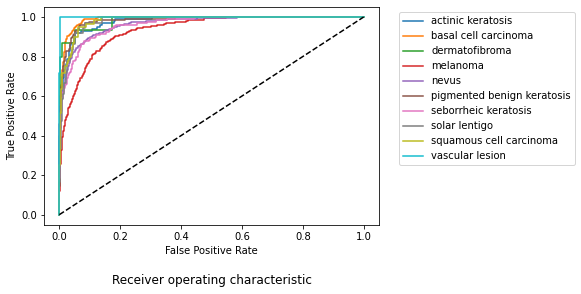

In [18]:
%matplotlib inline 

plt.rcParams['axes.titley'] = -0.3

for diagnosis in testing_set.class_indices:
    plt.plot(fpr[diagnosis], tpr[diagnosis], label=diagnosis)
    
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(bbox_to_anchor=(1.6, 1), loc="upper right")
plt.show()

## GradCam

In [19]:
melanoma_im_path = f"{os.environ['SCRATCH']}/isic-archive/ISIC_0000031.jpg"

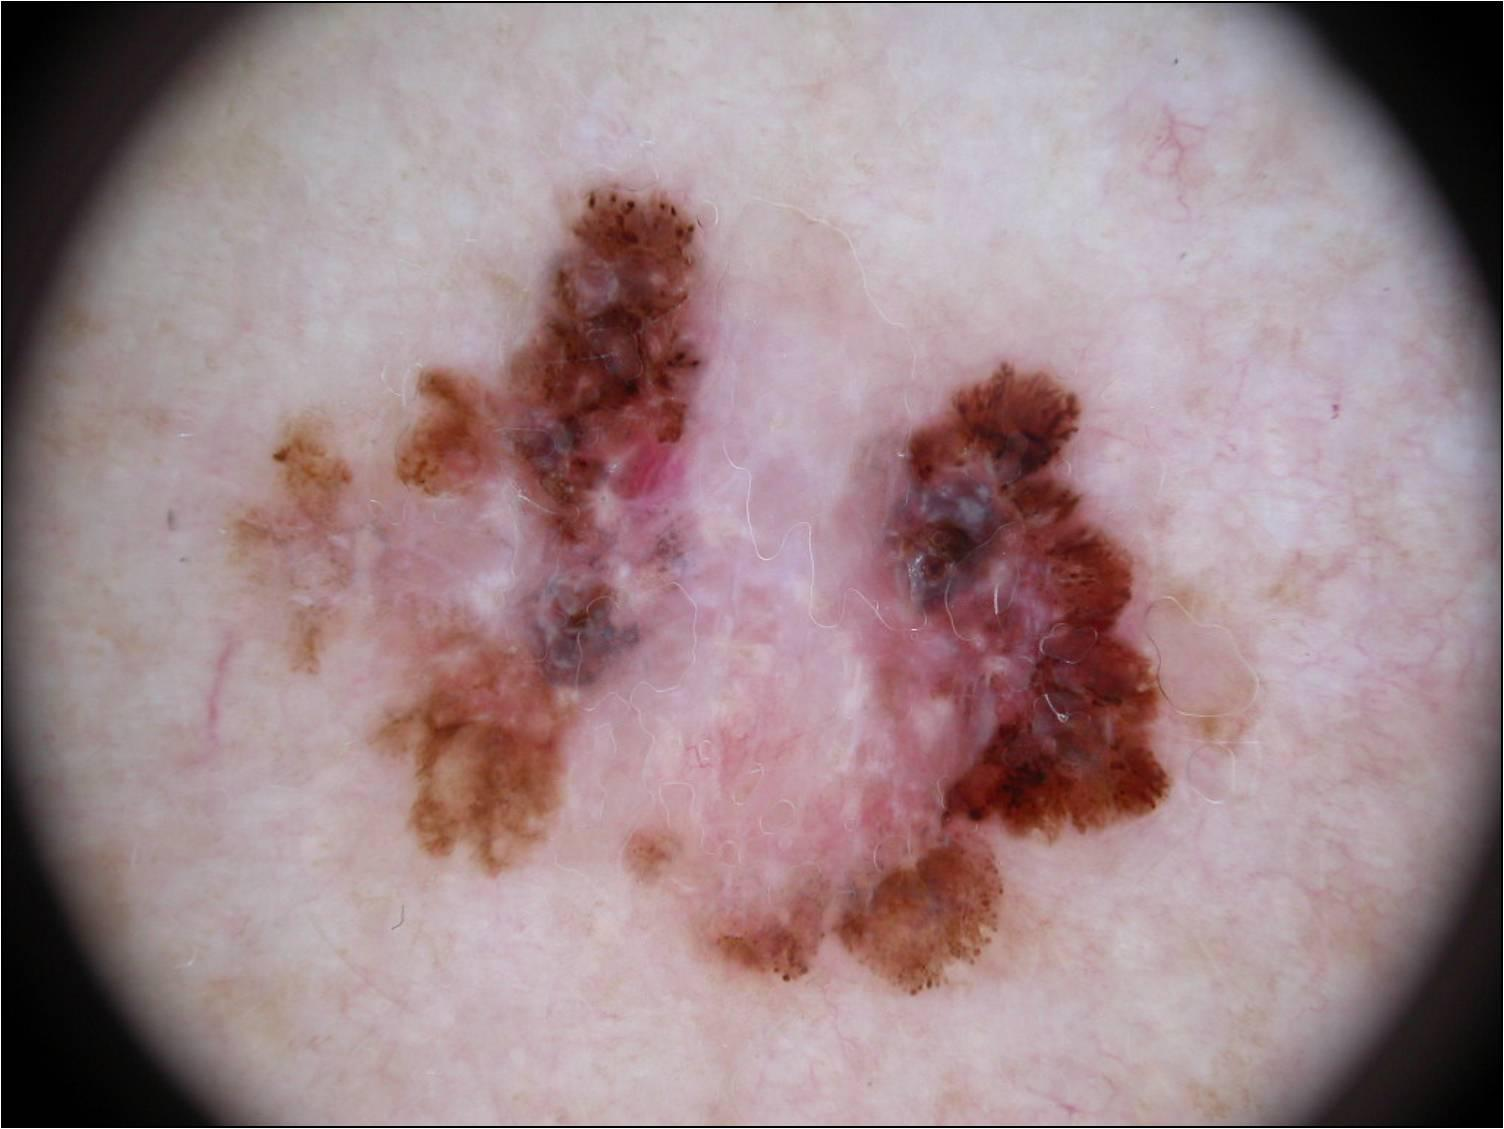

In [20]:
display(Image(melanoma_im_path, width=600))

In [21]:
img_array = PREPROCESSING(get_img_array(melanoma_im_path, size=(299, 299)))

In [22]:
heatmap = make_gradcam_heatmap(img_array, model.o_model, LAST_LAYER)

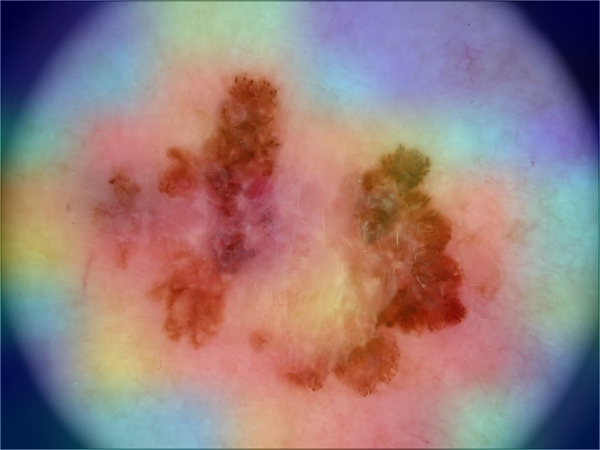

In [23]:
display_gradcam(melanoma_im_path, heatmap)